In [35]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
import os
import os.path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from user_function import MyAlgorithm
from alcon_utils import AlconUtils
import numpy as np
import cv2

def read_data(datasetdir):
    alcon = AlconUtils(datasetdir)

    # アノテーションの読み込み
    fn = "target_lv1.csv"
    alcon.load_annotations_target(fn)

    fn = "groundtruth_lv1.csv"
    alcon.load_annotations_ground(fn)

    # KNNモデルの作成
    dataset = {}
    for bb_id, target in alcon.targets.items():
        img_filename = alcon.get_filename_char( bb_id )
        code = alcon.ground_truth[bb_id][0]
        if code not in dataset:
            dataset[code] = []
        if len(dataset[code]) == 10:
            continue
        img = cv2.imread( img_filename )
        feature = MyAlgorithm.feature_extraction(img)
        dataset[code].append(feature)

    labels = []
    data = []
    classes = sorted(dataset.keys())
    for label, values in dataset.items():
        labels += [classes.index(label)] * len(values)
        data += values

    data = np.asarray(data, dtype=np.float)
    labels = np.asarray(labels, dtype=np.int)
    
    return data, labels
    
def main(datasetdir,lv):
    data, labels = read_data(datasetdir,lv)
    classifier = KNeighborsClassifier()
    classifier.fit(data, labels)

    outputfile = "./model.pkl"
    joblib.dump((classes, classifier), outputfile)

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

def main_keras_NN(datasetdir, lv):
    data, labels = read_data(datasetdir,lv)

    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.2
    K.tensorflow_backend.set_session(tf.Session(config=config))
    
    batch_size = 128
    num_classes = 46
    epochs = 12
    img_rows, img_cols = 32, 32
    
    data = data.reshape(data.shape[0],img_rows,img_cols,3)
    input_shape = (img_rows, img_cols, 3)
    data = data.astype('float32')
    labels = keras.utils.to_categorical(labels, num_classes)
    
    classifier = Sequential()
    
    classifier.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape,padding='same'))
    classifier.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(Dropout(0.25))
    classifier.add(Flatten())
    classifier.add(Dense(128,activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(num_classes, activation='softmax'))
    
    classifier.compile(loss=keras.losses.categorical_crossentropy,
                       optimizer=keras.optimizers.Adadelta(),
                       metrics=['accuracy'])
    
    classifier.fit(data,labels,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=None)

    outputfile = "./model.pkl"
    classifier.save(outputfile)

    outputfile2 = "./classes.pkl"
    joblib.dump(classes, outputfile2)

In [ ]:
if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("usage: python train.py datasetdir lv", file=sys.stderr)
        quit()

    main(sys.argv[1], sys.argv[2])

In [ ]:
#main_keras_NN("/share/alcon/dataset/","1")

Epoch 1/12


In [1]:
%pylab inline 
import matplotlib.pyplot as plt
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
image = cv2.imread("../dataset/characters/U+3042/U+3042_200022050-00014_2_X1979_Y2175.jpg")

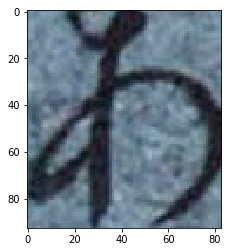

In [3]:
plt.imshow(image)

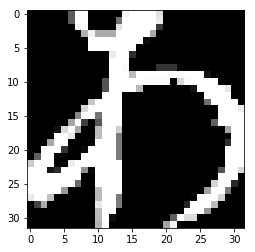

In [4]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur_image = cv2.bilateralFilter(gray_image, 14, 14, 3)
ret, binary_image = cv2.threshold(blur_image, 0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
img_ = cv2.resize(binary_image, (32, 32))
plt.imshow(img_, 'gray')

In [38]:
import numpy as np

kpw = np.array([[[ 0., 0., 0. ], [ 0., 1., 1. ], [ 0., 1., 0. ]],
                [[ 0., 0., 0. ], [ 0., 1., 0. ], [ 1., 1., 0. ]],
                [[ 0., 0., 0. ], [ 1., 1., 0. ], [ 0., 1., 0. ]],
                [[ 1., 0., 0. ], [ 1., 1., 0. ], [ 0., 0., 0. ]],
                [[ 0., 1., 0. ], [ 1., 1., 0. ], [ 0., 0., 0. ]],
                [[ 0., 1., 1. ], [ 0., 1., 0. ], [ 0., 0., 0. ]],
                [[ 0., 1., 0. ], [ 0., 1., 1. ], [ 0., 0., 0. ]],
                [[ 0., 0., 0. ], [ 0., 1., 1. ], [ 0., 0., 1. ]]])
kpb = np.array([[[ 1., 1., 0. ], [ 1., 0., 0. ], [ 0., 0., 0. ]],
                [[ 1., 1., 1. ], [ 0., 0., 0. ], [ 0., 0., 0. ]],
                [[ 0., 1., 1. ], [ 0., 0., 1. ], [ 0., 0., 0. ]],
                [[ 0., 0., 1. ], [ 0., 0., 1. ], [ 0., 0., 1. ]],
                [[ 0., 0., 0. ], [ 0., 0., 1. ], [ 0., 1., 1. ]],
                [[ 0., 0., 0. ], [ 0., 0., 0. ], [ 1., 1., 1. ]],
                [[ 0., 0., 0. ], [ 1., 0., 0. ], [ 1., 1., 0. ]],
                [[ 1., 0., 0. ], [ 1., 0., 0. ], [ 1., 0., 0. ]]])
src_w = np.array(img_, dtype=np.float32)/255.
thresh, src_b = cv2.threshold(src_w, 0.5, 1., cv2.THRESH_BINARY_INV)
thresh, src_f = cv2.threshold(src_w, 0.5, 1., cv2.THRESH_BINARY)
src_w = src_f.copy()
th = 1.
while th > 0:
    th = 0.
    for i in range(8):
        src_w = cv2.filter2D(src_w, cv2.CV_32F, kpw[i])
        src_b = cv2.filter2D(src_b, cv2.CV_32F, kpb[i])
        thresh, src_w = cv2.threshold(src_w, 2.99, 1, cv2.THRESH_BINARY)
        thresh, src_b = cv2.threshold(src_b, 2.99, 1, cv2.THRESH_BINARY)
        src_w = np.array(np.logical_and(src_w,src_b), dtype=np.float32)
        th += np.sum(src_w)
        src_f = np.array(np.logical_xor(src_f, src_w), dtype=np.float32)
        src_w = src_f.copy()
        thresh, src_b = cv2.threshold(src_f, 0.5, 1.0, cv2.THRESH_BINARY_INV)

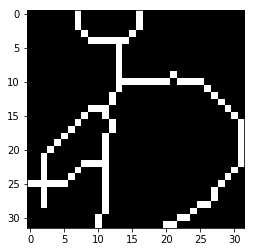

In [39]:
plt.imshow(src_f, "gray")

1393

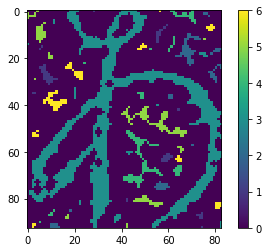

In [39]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 0)
data = binary.copy()
data[ binary == 0 ] = 255
data[ binary != 0 ] = 0

neiborhood8 = np.array([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]],
                       np.uint8)
neiborhood4 = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]],
                       np.uint8)

data = cv2.erode(data,
                 neiborhood4,
                 iterations=1)
 

#plt.imshow(data,cmap='gray')
n, label = cv2.connectedComponents(data)
plt.imshow(label * 5 % 7)
plt.colorbar()
area = np.zeros(n,dtype=np.int)
for row in label:
    for p in row:
        if p != 0:
            area[p] += 1
flag = np.zeros(n,dtype=np.int)
for i in range(len(area)):
    if area[i] > 500:
        flag[i] = 1.0
    else :
        flag[i] = 0.0
#print (flag)
for y in range(label.shape[0]):
    for x in range(label.shape[1]):
        data[y,x] = flag[ label[y,x] ]
        
data = cv2.dilate(data,
                 neiborhood4,
                 iterations=2)        
np.max(area)

In [5]:
plt.imshow(data,cmap='gray')

NameError: name 'data' is not defined

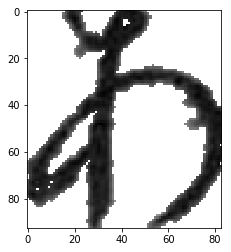

In [62]:
img = gray*data
img[ data == 0] = 255
plt.imshow(img,cmap='gray')

TypeError: Image data can not convert to float

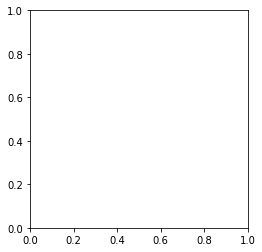

In [43]:
plt.imshow(image)